# Brain Tumor Classification

In this notebook I will be working with the following [Brain Tumor Dataset](https://www.kaggle.com/preetviradiya/brian-tumor-dataset). It contains X-Ray images of brain divided into two categories: brains with cancer and healthy brains. My goal is to build Deep Learning classifier that learns to label brain X-Rays as either healthy or having a cancer.

I treat this exercise as a practice in building deep learning model with PyTorch framework. Therefore, I will experiment with different neural network architectures. First, I will build a simple base model from scratch, then I will move to more sophisticated architectures, and utilize transfer learning to compare performance of some of the most popular models (vgg-16, LeNet, etc.) and obtain optimal performance.

# Imports

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torchvision
import torchvision.io as tvio
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, Subset

from torchinfo import summary

# Data Preprocessing

We start with plotting some of the images to get a general understanding of our dataset and decide if any preprocessing techniques should be applied.

In [12]:
def load_samples(root_dir, num):
    """ Loads {num} sample images for each category. """

    imgs = []
    lbls = []
    
    for root, dirs, files in os.walk(root_dir):
        for idx, filename in enumerate(files):
            filepath = root + os.sep + filename
            img = cv2.imread(filepath)
            imgs.append(img)
            label = root.split('\\')[1]
            lbls.append(label)
            if idx+1 == num: break
            
    return X, y


def plot_samples(root_dir, num=10):
    """ Plots {num} sample images for each category. """
    
    imgs, lbls = load_samples(root_dir, num)
    ncols = 10
    nrows = int(2*num/ncols)

    plt.figure(figsize=(18, 10))
    for idx, (img, label) in enumerate(zip(imgs, lbls)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.imshow(img)
        plt.xlabel(label)
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

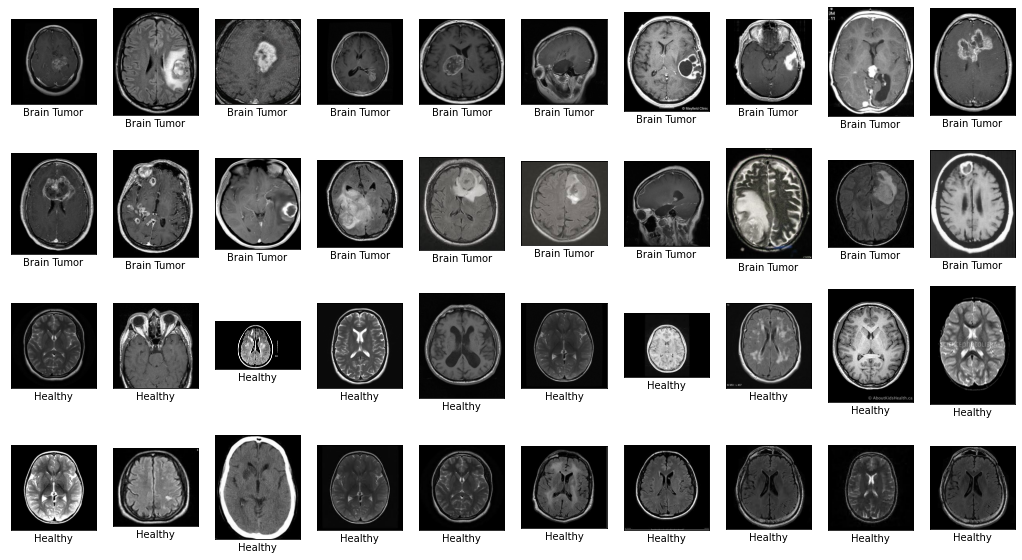

In [13]:
root_dir = 'data/Brain Tumor Data Set'
plot_samples(root_dir, 20)

# Data Loading

In [6]:
train_transform = transforms.Compose([transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC), 
                                      transforms.ColorJitter(brightness=(0.1, 1.5)), 
                                      transforms.RandomRotation(10), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomVerticalFlip(), 
                                      transforms.ToTensor()])

val_transform = transforms.Compose([transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
                                    transforms.ToTensor()])
                                    

root_dir = 'data/Brain Tumor Data Set'
train_dataset = torchvision.datasets.ImageFolder(root_dir, train_transform)
val_dataset = torchvision.datasets.ImageFolder(root_dir, val_transform)


# Create the index splits for training and validation
train_size = 0.8
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.shuffle(indices)
train_idx, val_idx = indices[:split], indices[split:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=val_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)

((tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  1),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 